<a href="https://colab.research.google.com/github/nicolassalomon96/aprendizaje_maquina_UNS/blob/master/TP3/KNN-3.3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TP3 - Clasificador KNN

### Ejercicio 3.3: En el notebook https://github.com/manlio99/Materia-de-aprendizaje/blob/master/3_MidtermProjects/musica.ipynb hay un dataset con 2000+ canciones de Spotify de una usuaria, donde algunas fueron marcadas como gustadas y otras no. Cada canción tiene a su vez 16 atributos (nombre, artista, duración, bailable, etc.). Desarrollar un clasificador que prediga si una canción dada va a ser gustada o no. Aclarar y justificar los pasos, analizar y explicar los resultados.

## 1. Librerias necesarias

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn import neighbors
from sklearn import metrics

from sklearn.feature_selection import f_classif
from sklearn.feature_selection import RFE
from sklearn.ensemble import ExtraTreesClassifier

## 2. Se importa el dataset

In [ ]:
import pandas as pd
#leemos el dataset
attributes_spotify = pd.read_csv("https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectBOM/data/attributes_spotify.csv")
display(attributes_spotify)

,Unnamed: 0,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,target,song_title,artist
0,0,0.01020,0.833,204600,0.434,0.021900,2,0.1650,-8.795,1,0.4310,150.062,4.0,0.286,1,Mask Off,Future
1,1,0.19900,0.743,326933,0.359,0.006110,1,0.1370,-10.401,1,0.0794,160.083,4.0,0.588,1,Redbone,Childish Gambino
2,2,0.03440,0.838,185707,0.412,0.000234,2,0.1590,-7.148,1,0.2890,75.044,4.0,0.173,1,Xanny Family,Future
3,3,0.60400,0.494,199413,0.338,0.510000,5,0.0922,-15.236,1,0.0261,86.468,4.0,0.230,1,Master Of None,Beach House
4,4,0.18000,0.678,392893,0.561,0.512000,5,0.4390,-11.648,0,0.0694,174.004,4.0,0.904,1,Parallel Lines,Junior Boys
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012,2012,0.00106,0.584,274404,0.932,0.002690,1,0.1290,-3.501,1,0.3330,74.976,4.0,0.211,0,Like A Bitch - Kill The Noise Remix,Kill The Noise
2013,2013,0.08770,0.894,182182,0.892,0.001670,1,0.0528,-2.663,1,0.1310,110.041,4.0,0.867,0,Candy,Dillon Francis
2014,2014,0.00857,0.637,207200,0.935,0.003990,0,0.2140,-2.467,1,0.1070,150.082,4.0,0.470,0,Habit - Dack Janiels & Wenzday Remix,Rain Man
2015,2015,0.00164,0.557,185600,0.992,0.677000,1,0.0913,-2.735,1,0.1330,150.011,4.0,0.623,0,First Contact,Twin Moons


## 3. Análisis del dataset

In [ ]:
display(attributes_spotify.describe())

,Unnamed: 0,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,target
count,2017.000000,2017.000000,2017.000000,2.017000e+03,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000
mean,1008.000000,0.187590,0.618422,2.463062e+05,0.681577,0.133286,5.342588,0.190844,-7.085624,0.612295,0.092664,121.603272,3.968270,0.496815,0.505702
std,582.402066,0.259989,0.161029,8.198181e+04,0.210273,0.273162,3.648240,0.155453,3.761684,0.487347,0.089931,26.685604,0.255853,0.247195,0.500091
min,0.000000,0.000003,0.122000,1.604200e+04,0.014800,0.000000,0.000000,0.018800,-33.097000,0.000000,0.023100,47.859000,1.000000,0.034800,0.000000
25%,504.000000,0.009630,0.514000,2.000150e+05,0.563000,0.000000,2.000000,0.092300,-8.394000,0.000000,0.037500,100.189000,4.000000,0.295000,0.000000
50%,1008.000000,0.063300,0.631000,2.292610e+05,0.715000,0.000076,6.000000,0.127000,-6.248000,1.000000,0.054900,121.427000,4.000000,0.492000,1.000000
75%,1512.000000,0.265000,0.738000,2.703330e+05,0.846000,0.054000,9.000000,0.247000,-4.746000,1.000000,0.108000,137.849000,4.000000,0.691000,1.000000
max,2016.000000,0.995000,0.984000,1.004627e+06,0.998000,0.976000,11.000000,0.969000,-0.307000,1.000000,0.816000,219.331000,5.000000,0.992000,1.000000


In [ ]:
#Cantidad de canciones que le gustó o no a la usuaria
attributes_spotify.groupby('target').size()

target
0     997
1    1020
dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


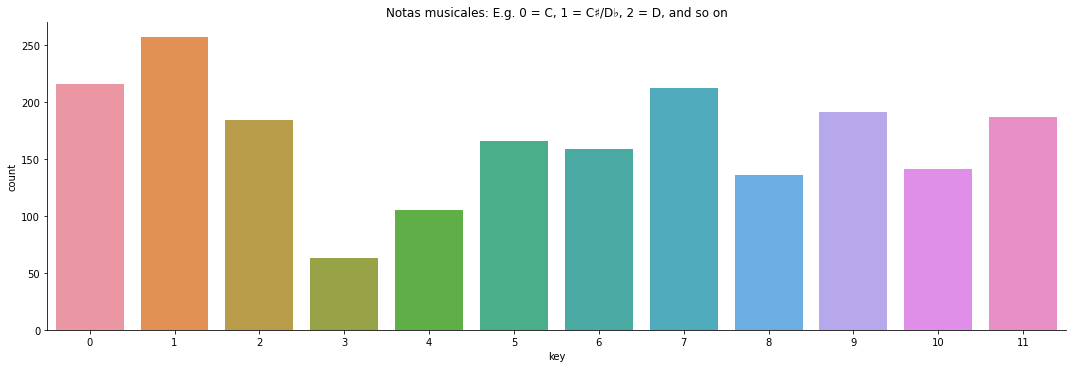

In [ ]:
#Veces que aparecieron canciones con determinados tonos musicales
sb.catplot('key', data=attributes_spotify,kind="count", aspect=3).set(title="Notas musicales: E.g. 0 = C, 1 = C♯/D♭, 2 = D, and so on")
plt.show()

## 4. Clasificador por K-NN

Aplicaremos la eliminación recursiva de atributos. Dado un modelo predictivo se asigna un coeficiente de importancia a cada atributo emplenado la clase ExtraTreesClassifier, la cuál implementa un metaestimador que se ajusta a una serie de árboles de decisión aleatorios en varias submuestras del conjunto de datos y utiliza promedios para mejorar la precisión predictiva.

El objetivo de la Eliminación Recursiva de atributos es ir seleccionado en forma recursiva un número cada vez más pequeño de atributos. Primero comienza con todos los atributos del dataset y luego en cada pasada va eliminando aquellos que tenga el menor coeficiente de importancia hasta alcanzar el número de atributos deseado.

In [ ]:
#Separamos la columna objetivo
target = attributes_spotify['target']

#Eliminamos la columna objetivo del dataset
attributes_spotify_mod = attributes_spotify.drop(['target', 'song_title', 'artist', 'Unnamed: 0'], axis=1)
columnas = list(attributes_spotify_mod.columns.values)

n = 4 #Número de atributos a seleccionar
modelo = ExtraTreesClassifier()
recursive_delete = RFE(modelo, n)
recursive_delete = recursive_delete.fit(attributes_spotify_mod, target)

In [ ]:
# imprimir resultados
atrib = recursive_delete.support_
relevant_features = [columnas[i] for i in list(atrib.nonzero()[0])]
relevant_features

['energy', 'instrumentalness', 'loudness', 'speechiness']

In [ ]:
relevant_features.append('target') #Volvemos a incluir el atributo target junto con los atributos mas relevantes

In [ ]:
spotify_df = attributes_spotify[relevant_features]
spotify_df

,energy,instrumentalness,loudness,speechiness,target
0,0.434,0.021900,-8.795,0.4310,1
1,0.359,0.006110,-10.401,0.0794,1
2,0.412,0.000234,-7.148,0.2890,1
3,0.338,0.510000,-15.236,0.0261,1
4,0.561,0.512000,-11.648,0.0694,1
...,...,...,...,...,...
2012,0.932,0.002690,-3.501,0.3330,0
2013,0.892,0.001670,-2.663,0.1310,0
2014,0.935,0.003990,-2.467,0.1070,0
2015,0.992,0.677000,-2.735,0.1330,0


In [ ]:
#Función para separar el dataset en entrenamiento, validación y prueba
def train_validate_test_split(df, train_percent=.6, validate_percent=.2):
    np.random.seed(1)
    perm = np.random.permutation(df.index)
    m = len(df.index)
    train_end = int(train_percent * m)
    validate_end = int(validate_percent * m) + train_end
    train = df.iloc[perm[:train_end]]
    validate = df.iloc[perm[train_end:validate_end]]
    test = df.iloc[perm[validate_end:]]
    return train, validate, test

In [ ]:
train, validate, test = train_validate_test_split(spotify_df, 0.9, 0.07)
print(f"Datos de entrenamiento: {train.shape}")
print(f"Datos de validacion: {validate.shape}")
print(f"Datos de prueba: {test.shape}")

X_train = train.iloc[:,:-1]
y_train = train.iloc[:,-1] #Atributo objetivo: target

X_validate = validate.iloc[:,:-1]
y_validate = validate.iloc[:,-1] #Atributo objetivo: target

X_test = test.iloc[:,:-1]
y_test = test.iloc[:,-1] #Atributo objetivo: target

Datos de entrenamiento: (1815, 5)
Datos de validacion: (141, 5)
Datos de prueba: (61, 5)


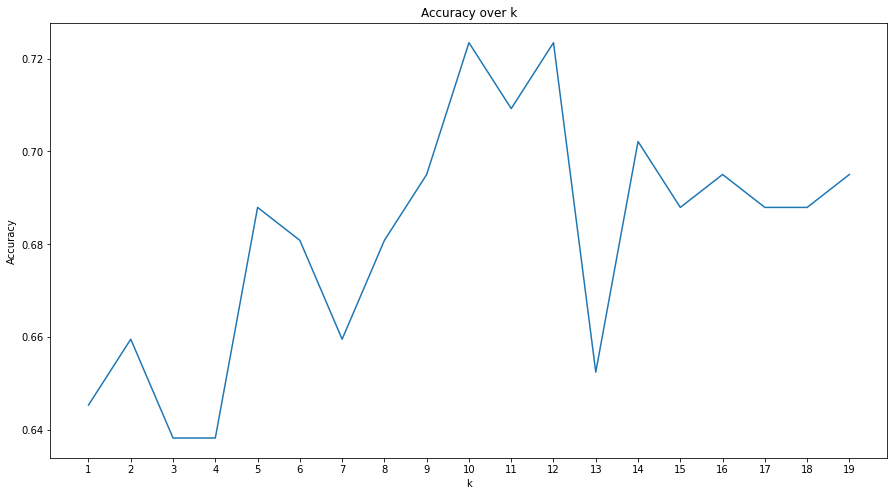

In [ ]:
#Observamos la precisión en función de k, para obtener el valor de k óptimo
scores = []
x_range = []
for k1 in range(1,20):
  knn1 = neighbors.KNeighborsClassifier(n_neighbors=k1)
  knn1.fit(X_train, y_train)
  scores.append(knn1.score(X_validate, y_validate))
  x_range.append(k1)

plt.figure(figsize=(15,8))
plt.plot(x_range,scores)
plt.xticks(x_range)
plt.title("Accuracy over k")
plt.xlabel("k")
plt.ylabel("Accuracy")
plt.show()

In [ ]:
k = 10 #nº de vecinos mas cercanos para tener la máxima presición
knn = neighbors.KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train, y_train)
print(f"Modelo entrenado - Accuracy: {round(knn.score(X_validate, y_validate)*100,2)}%")

Modelo entrenado - Accuracy: 72.34%


Observación: Los mejores valores de porcentajes de división del dataset en entrenamiento, validación y prueba, así como también el valor de n (número de atributos a seleccionar) se obtuvieron de forma experimental.

## 5. Análisis de resultados sobre el dataset de prueba

Metricas de medición:

              precision    recall  f1-score   support

           0       0.68      0.72      0.70        29
           1       0.73      0.69      0.71        32

    accuracy                           0.70        61
   macro avg       0.71      0.71      0.70        61
weighted avg       0.71      0.70      0.71        61



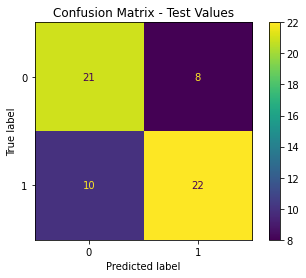

In [ ]:
y_predicted = knn.predict(X_test)
print("Metricas de medición:\n")
print(f"{metrics.classification_report(y_test, y_predicted)}")

confusion_matrix = metrics.plot_confusion_matrix(knn, X_test, y_test)
plt.title("Confusion Matrix - Test Values")
plt.show()

Tomaremos 20 muestras del set de pruebas para observar los resultados obtenidos de la predicción

In [ ]:
for i in range(20):
  prediction = y_predicted[i]
  true = attributes_spotify.iloc[X_test.index.values[i],:]['target']
  name = attributes_spotify.iloc[X_test.index.values[i],:]['song_title']
  print(f"Predicted: {prediction} - True: {true} - Song_name: {name}")

Predicted: 0 - True: 0 - Song_name: There's Nothing Holdin' Me Back - NOTD Remix
Predicted: 1 - True: 0 - Song_name: Neighbors
Predicted: 0 - True: 0 - Song_name: Me Enamoré
Predicted: 1 - True: 1 - Song_name: Cloud Atlas End Title
Predicted: 0 - True: 1 - Song_name: Computer Love
Predicted: 1 - True: 1 - Song_name: Levitate
Predicted: 1 - True: 1 - Song_name: Mornin'
Predicted: 0 - True: 1 - Song_name: Now Is Not the Time
Predicted: 0 - True: 0 - Song_name: Help
Predicted: 1 - True: 1 - Song_name: White Noise
Predicted: 0 - True: 0 - Song_name: TESTIFY
Predicted: 0 - True: 1 - Song_name: Black Out Days
Predicted: 0 - True: 1 - Song_name: Ambling Alp
Predicted: 0 - True: 0 - Song_name: Remember the Time
Predicted: 1 - True: 1 - Song_name: Best Night
Predicted: 1 - True: 0 - Song_name: Manufactured Existence
Predicted: 1 - True: 0 - Song_name: The Folks Who Live on the Hill
Predicted: 1 - True: 1 - Song_name: Topless
Predicted: 1 - True: 1 - Song_name: Who Is He (And What Is He to You?)

Total aciertos: 43 - Total desaciertos: 18


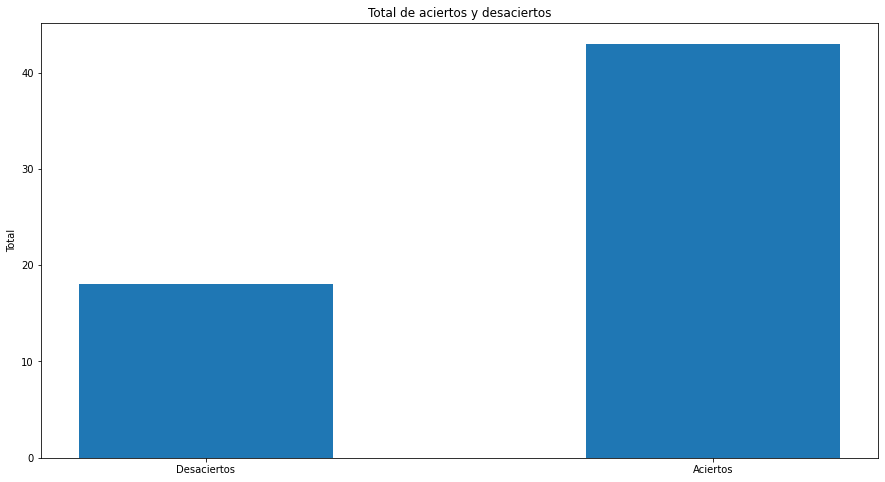

In [ ]:
true = 0
false = 0
for i in range(len(y_predicted)):
  prediction = y_predicted[i]
  true_value = attributes_spotify.iloc[X_test.index.values[i],:]['target']
  
  if prediction == true_value:
    true += 1
  else:
    false += 1

print(f"Total aciertos: {true} - Total desaciertos: {false}")
eje_x = ['Desaciertos', 'Aciertos']
eje_y = [false, true]

plt.figure(figsize=(15,8)) 
plt.bar(eje_x, eje_y, width=0.5)
plt.ylabel('Total')
plt.title('Total de aciertos y desaciertos')
plt.show()


## 6. Conclusión

Se observa como la presición empleando el set de pruebas es muy cercana a la presición obtenida durante el entrenamiento y validación.

Por otro lado es importante descatcar que para obtener la mejor permorfance posible en el clasificador, es necesario variar no solo el valor de *k (nº de vecinos mas cercanos)* sino también el valor de *n (número de atributos a seleccionar)* y los porcentajes de divisón del dataset (entrenamiento, validación y test)